Model for Stock Analysis\
Use PANI.JK as an example for a volatile stock

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

Data Extraction

In [49]:
# Define the stock ticker and the time period
ticker = 'PANI.JK'
start_date = '2021-01-25'
end_date = '2024-11-17'

# Download the data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price                     Adj Close     Close      High       Low      Open  \
Ticker                      PANI.JK   PANI.JK   PANI.JK   PANI.JK   PANI.JK   
Date                                                                          
2021-01-25 00:00:00+00:00  7.527827  7.530939  7.673032  7.104660  7.388846   
2021-01-26 00:00:00+00:00  7.527827  7.530939  8.596638  7.530939  7.530939   
2021-01-27 00:00:00+00:00  7.811896  7.815126  7.815126  7.459893  7.459893   
2021-01-28 00:00:00+00:00  7.669861  7.673032  7.744079  7.601986  7.744079   
2021-01-29 00:00:00+00:00  7.527827  7.530939  7.744079  7.175706  7.601986   

Price                       Volume  
Ticker                     PANI.JK  
Date                                
2021-01-25 00:00:00+00:00  7133346  
2021-01-26 00:00:00+00:00   125269  
2021-01-27 00:00:00+00:00    36595  
2021-01-28 00:00:00+00:00    71783  
2021-01-29 00:00:00+00:00   371587  


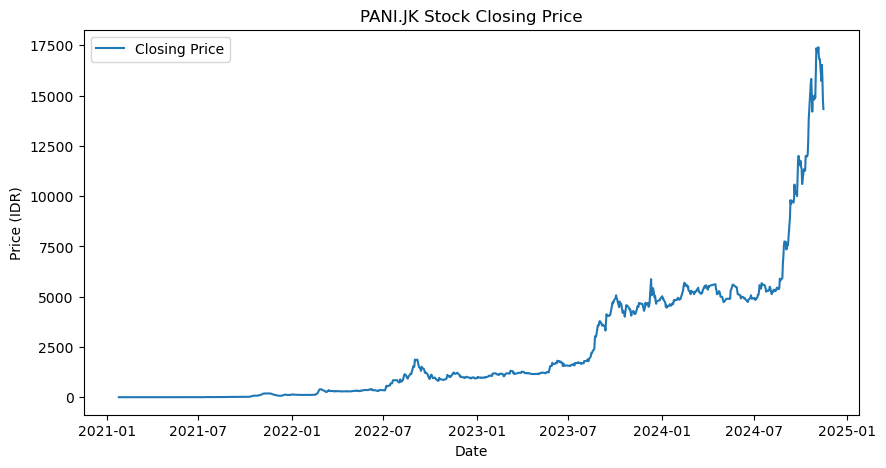

In [46]:
# Plot the closing price
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'], label='Closing Price')
plt.title(f'{ticker} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.show()


Data Preprocessing

In [50]:
# Check for missing values
print(stock_data.isnull().sum())

# stock_data.fillna(method='ffill', inplace=True) # If there are any missing values
stock_data.reset_index(inplace=True)
print(stock_data.columns)
print(stock_data.head)

Price      Ticker 
Adj Close  PANI.JK    0
Close      PANI.JK    0
High       PANI.JK    0
Low        PANI.JK    0
Open       PANI.JK    0
Volume     PANI.JK    0
dtype: int64
MultiIndex([(     'Date',        ''),
            ('Adj Close', 'PANI.JK'),
            (    'Close', 'PANI.JK'),
            (     'High', 'PANI.JK'),
            (      'Low', 'PANI.JK'),
            (     'Open', 'PANI.JK'),
            (   'Volume', 'PANI.JK')],
           names=['Price', 'Ticker'])
<bound method NDFrame.head of Price                       Date     Adj Close         Close          High  \
Ticker                                 PANI.JK       PANI.JK       PANI.JK   
0      2021-01-25 00:00:00+00:00      7.527827      7.530939      7.673032   
1      2021-01-26 00:00:00+00:00      7.527827      7.530939      8.596638   
2      2021-01-27 00:00:00+00:00      7.811896      7.815126      7.815126   
3      2021-01-28 00:00:00+00:00      7.669861      7.673032      7.744079   
4      2021-01-29 00:

### Flatten column for prophet data preparation
#### Prophet model did not accept multiple index 

In [54]:
prophet_stock_data = stock_data[['Date','Close']].copy()
prophet_stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in prophet_stock_data.columns]
print(prophet_stock_data.columns)

Index(['Date_', 'Close_PANI.JK'], dtype='object')


Feature Selection\
'data' for LSTM\
'prophet_data' for prophet

In [64]:
# 'Close' column to indicate final prices each day
data = stock_data[['Close']]

# Data for prophet
prophet_data = prophet_stock_data[['Date_','Close_PANI.JK']].copy()
prophet_data.rename(columns={'Date_':'ds', 'Close_PANI.JK':'y'}, inplace=True)
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])
prophet_data['ds'] = prophet_data['ds'].dt.tz_localize(None)

# Check the first few rows
print("Prophet Data: ")
print(prophet_data.head())
print("LSTM Data: ")
print(data.head())

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_data = scaler.fit_transform(data)

# Convert back to a DataFrame for easier handling
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=['Close'])

Prophet Data: 
          ds         y
0 2021-01-25  7.530939
1 2021-01-26  7.530939
2 2021-01-27  7.815126
3 2021-01-28  7.673032
4 2021-01-29  7.530939
LSTM Data: 
Price      Close
Ticker   PANI.JK
0       7.530939
1       7.530939
2       7.815126
3       7.673032
4       7.530939


LSTM Model

In [56]:
# Time-series data sequence and splitting
window_size = 20 # Number of past days used for prediction
X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data.iloc[i-window_size:i, 0])
    y.append(scaled_data.iloc[i, 0])

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define split size
split_ratio = 0.8 # 80% training, 20% testing
split_index = int(len(X) * split_ratio)

# Split the data
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f'Training data size: {X_train.shape}, Testing data size: {X_test.shape}')

Training data size: (724, 20, 1), Testing data size: (182, 20, 1)


Model Building and Training

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# Adding the first LSTM layer with Dropout
model.add(LSTM(units=90, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))

# Adding a second LSTM layer with Dropout
model.add(LSTM(units=90, return_sequences=True))
model.add(Dropout(0.3))

# Adding a third LSTM layer with Dropout
model.add(LSTM(units=90, return_sequences=False))
model.add(Dropout(0.3))

# Adding the output layer
model.add(Dense(units=1))  # Output layer for predicting the next closing price

from tensorflow.keras.optimizers import Adam
# Compile the model
#model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error')
model.compile(optimizer='adam', loss='mean_absolute_error')

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 90)            33120     
                                                                 
 dropout_6 (Dropout)         (None, 20, 90)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20, 90)            65160     
                                                                 
 dropout_7 (Dropout)         (None, 20, 90)            0         
                                                                 
 lstm_8 (LSTM)               (None, 90)                65160     
                                                                 
 dropout_8 (Dropout)         (None, 90)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [58]:
# Model Training
# Use callback
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
callback = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
epochs = 50
batch_size = 64

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[callback]
)

Epoch 1/50
10/10 [==============================] - 13s 335ms/step - loss: 0.0189 - val_loss: 0.0642
Epoch 2/50
10/10 [==============================] - 1s 97ms/step - loss: 0.0092 - val_loss: 0.0546
Epoch 3/50
10/10 [==============================] - 1s 78ms/step - loss: 0.0079 - val_loss: 0.0216
Epoch 4/50
10/10 [==============================] - 1s 83ms/step - loss: 0.0093 - val_loss: 0.0371
Epoch 5/50
10/10 [==============================] - 1s 87ms/step - loss: 0.0069 - val_loss: 0.0202
Epoch 6/50
10/10 [==============================] - 1s 103ms/step - loss: 0.0068 - val_loss: 0.0372
Epoch 7/50
10/10 [==============================] - 1s 103ms/step - loss: 0.0070 - val_loss: 0.0175
Epoch 8/50
10/10 [==============================] - 1s 84ms/step - loss: 0.0059 - val_loss: 0.0197
Epoch 9/50
10/10 [==============================] - 1s 86ms/step - loss: 0.0058 - val_loss: 0.0182
Epoch 10/50
10/10 [==============================] - 1s 100ms/step - loss: 0.0054 - val_loss: 0.0169
Epoc

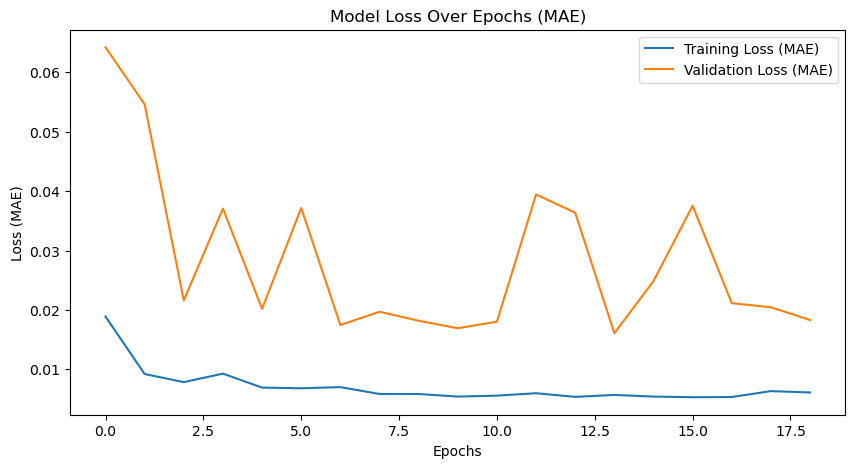

In [59]:
# Plot Training Result
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MAE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
plt.title('Model Loss Over Epochs (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

Model Testing

6/6 [==============================] - 2s 29ms/step


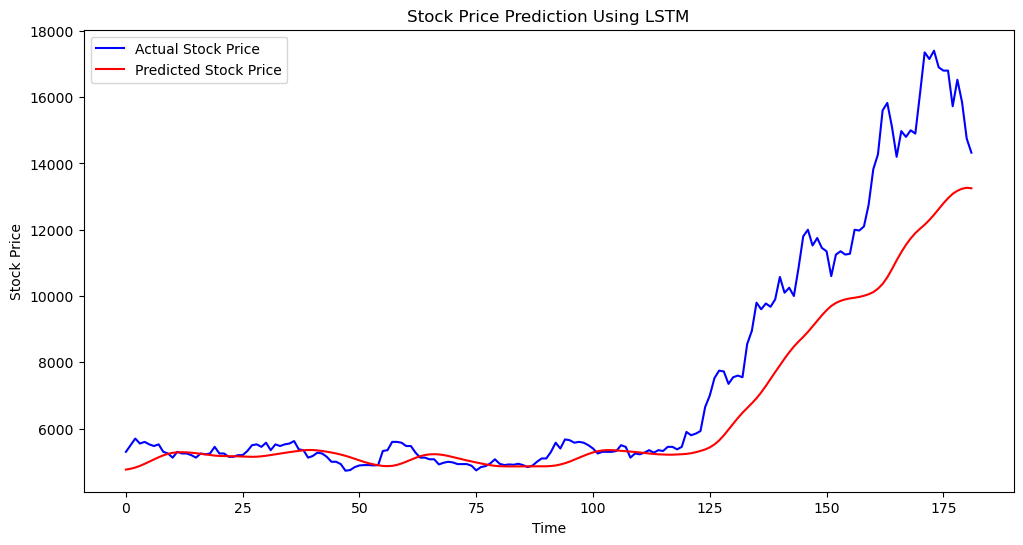

In [60]:
# Make predictions using the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual and predicted price
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction Using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [61]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

avg_price = y_test.mean()
mae_percent = (mae / avg_price) * 100
print(f"MAE as a Percentage of Average Price: {mae_percent:.2f}%")

Mean Absolute Error (MAE): 993.7306
Mean Squared Error (MSE): 2686735.5670
Root Mean Squared Error (RMSE): 1639.1265
MAE as a Percentage of Average Price: 13.35%


Prophet Model

In [ ]:
prophet_model = Prophet()
prophet_model.fit(prophet_data)

16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Future Testing

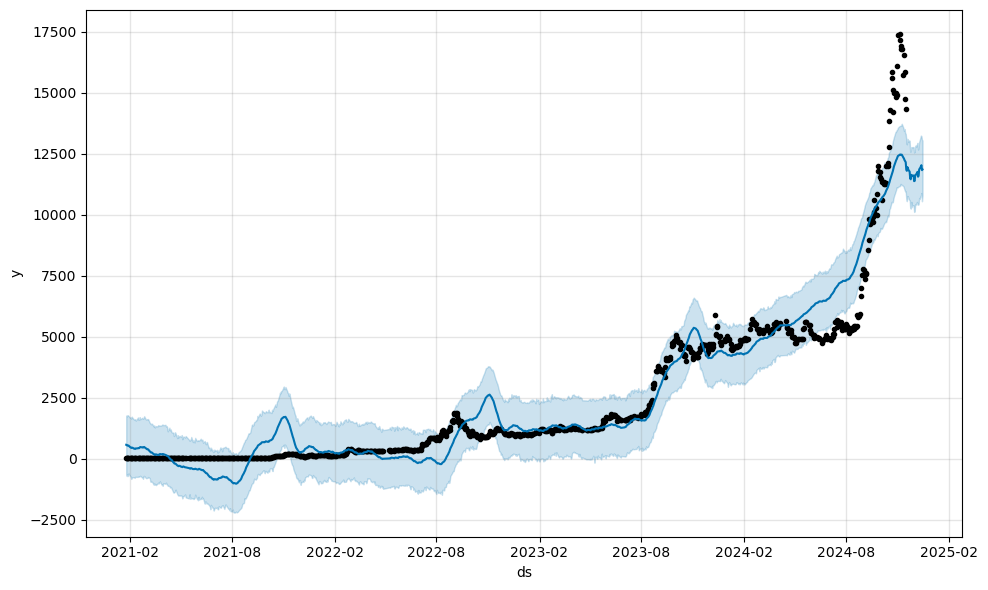

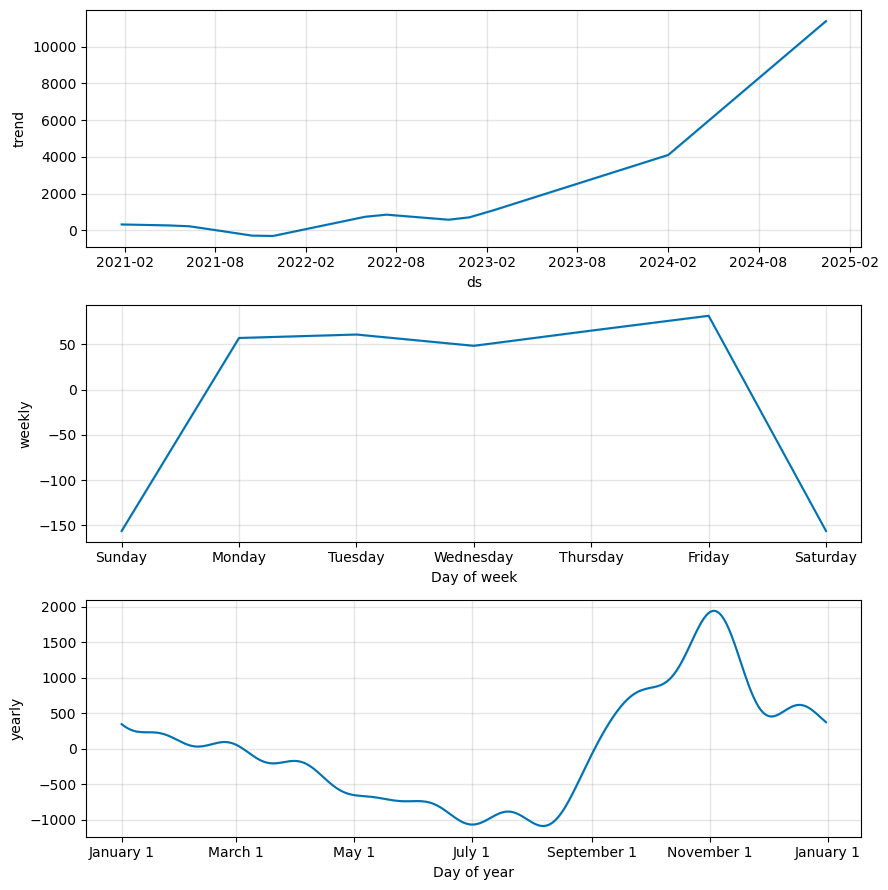

In [73]:
future_prophet = prophet_model.make_future_dataframe(periods=30)
forecast_prophet = prophet_model.predict(future_prophet)

fig_prophet = prophet_model.plot(forecast_prophet)
plt.show()
fig_prophet_components = prophet_model.plot_components(forecast_prophet)
plt.show()

MAE Evaluation

In [74]:
from sklearn.metrics import mean_absolute_error

# Merge forecasted values with actual values based on the date
df_merged = forecast_prophet[['ds', 'yhat']].merge(prophet_data, on='ds', how='inner')

# Extract actual and predicted values
y_actual = df_merged['y']
y_pred = df_merged['yhat']

# Compute MAE
mae = mean_absolute_error(y_actual, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Mean Absolute Error (MAE): 627.2436


Save Model

1. LSTM

In [69]:
from tensorflow.keras.models import save_model

# Save the model to a file
model.save("lstm_PANIJK_model.h5")

2. Prophet

In [70]:
import pickle

# Save the trained Prophet model
with open('prophet_PANIJK_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)